# Exercise 01a

Metadata is descriptive and often standardized information about a dataset. It is information that allows new users of a dataset to understand the contents of a file that was created by someone else. By including metadata, your data set can be used as intended by many more people and the information is useful log past the creators interest in it or even their lifetime.

Many now operate by principles of fair data, some data centers REQUIRE it. This entails using standardized conventions such as CF and ACDD in the file above. These conventions give users a standardized vocabulary and structure such that future users can easily interpret and use the data. Here CF mainly gives a standard for the file structure, variable names and standardized attributes. ACDD focuses more on metadata and and global attributes such that the data is easily discoverable for potential users.

In [393]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cy
from matplotlib.animation import FuncAnimation

In [394]:
url='https://thredds.met.no/thredds/dodsC/aromearcticlatest/latest/arome_arctic_lagged_12_h_latest_2_5km_latest.nc'
dataset = xr.open_dataset(url, engine='netcdf4')

In [395]:
dataset.data_vars

Data variables:
    forecast_reference_time    datetime64[ns] 8B ...
    projection_lambert         int32 4B ...
    x_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    y_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_pl         (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_2m         (time, height0, ensemble_member, y, x) float32 651MB ...
    relative_humidity_2m       (time, height0, ensemble_member, y, x) float32 651MB ...
    x_wind_10m                 (time, height2, ensemble_member, y, x) float32 651MB ...
    y_wind_10m                 (time, height2, ensemble_member, y, x) float32 651MB ...
    cloud_area_fraction        (time, height1, ensemble_member, y, x) float32 651MB ...
    air_pressure_at_sea_level  (time, height_above_msl, ensemble_member, y, x) float32 651MB ...
    precipitation_amount_acc   (time, height1, ensemble_member, y, x) float32 651MB ...
 

In [396]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    x=int(x[0])
    y=int(y[0])
   
    return (x,y)

def find_data_point(lon, lat, data_var, dataset):
    lon = 15.46; lat= 78.24
    [xloc,yloc] = findindex(dataset.latitude,dataset.longitude,lat,lon) 

    t2m_point = dataset.data_vars[data_var][:,0,1,xloc,yloc]
    return t2m_point


def plot_timeseries(lon, lat, data_var, dataset, title = ''):
    data_point = find_data_point(lon, lat, data_var, dataset)
    unit = dataset.data_vars[data_var].attrs['units']
    
    plt.figure(figsize=(10,4))
    plt.plot(dataset.time, data_point, '-')

    plt.title(title)
    plt.xlabel('Date Time')
    plt.ylabel(f'{data_var} [{unit}]')
    plt.show()


def plot_2mtemp_map(ensemble_mem, timestep, lon, lat, dataset):
    if isinstance(timestep, str):
        time_hours = dataset.data_vars['air_temperature_2m'].time
        target_time = np.datetime64(timestep)
        timestep = np.where(time_hours == target_time)[0][0]
        # timestep = date_time
    try:
        data_area = dataset.data_vars['air_temperature_2m'][timestep,0,ensemble_mem,:,:]
    except:
        data_area = dataset.data_vars['air_temperature_2m'][timestep,0,:,:]
    date_time = dataset.data_vars['air_temperature_2m'].time.values[timestep]

    unit = dataset.data_vars['air_temperature_2m'].attrs['units']

    projection = cy.crs.LambertConformal(central_longitude =dataset.projection_lambert.longitude_of_central_meridian,
                                        central_latitude  =dataset.projection_lambert.latitude_of_projection_origin,
                                        standard_parallels = dataset.projection_lambert.standard_parallel)
    fig = plt.figure(figsize=[8, 8])

    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([lon - 1.5, lon + 1.5, lat-1.5, lat+1.5], cy.crs.PlateCarree())
    ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=cy.crs.PlateCarree())

    ax.gridlines()
    ax.add_feature(cy.feature.COASTLINE, zorder=2) 
    cf = ax.pcolormesh(data_area.longitude,data_area.latitude,data_area[:,:],transform=cy.crs.PlateCarree(), zorder=1)
    val_from = np.min(data_area.values)
    val_to = np.max(data_area.values)
    cf.set_clim(val_from, val_to)
    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False

    cbaxes = fig.add_axes([0.92, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both')
    cbar.set_label(f'2m Temperature [{unit}]')

    date_time = date_time.astype('datetime64[h]')
    fig.suptitle(f'Temperature forecast: {date_time}')


def plot_pressure_map(ensemble_mem, timestep, lon, lat, dataset, wind_field=False):
    if isinstance(timestep, str):
        time_hours = dataset.data_vars['air_pressure_at_sea_level'].time
        target_time = np.datetime64(timestep)
        timestep = np.where(time_hours == target_time)[0][0]
        # timestep = date_time

    try:
        data_area = dataset.data_vars['air_pressure_at_sea_level'][timestep,0,ensemble_mem,:,:]
    except:
        data_area = dataset.data_vars['air_pressure_at_sea_level'][timestep,0,:,:]
    date_time = dataset.data_vars['air_pressure_at_sea_level'].time.values[timestep]

    unit = dataset.data_vars['air_pressure_at_sea_level'].attrs['units']

    projection = cy.crs.LambertConformal(central_longitude =dataset.projection_lambert.longitude_of_central_meridian,
                                        central_latitude  =dataset.projection_lambert.latitude_of_projection_origin,
                                        standard_parallels = dataset.projection_lambert.standard_parallel)
    fig = plt.figure(figsize=[8, 8])

    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([lon - 4.5, lon + 4.5, lat-4.5, lat+4.5], cy.crs.PlateCarree())
    ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=cy.crs.PlateCarree())

    ax.gridlines()
    ax.add_feature(cy.feature.COASTLINE, zorder=2) 
    cf = ax.contourf(data_area.longitude, data_area.latitude, data_area[:, :], 
                 transform=cy.crs.PlateCarree(), zorder=1, cmap='viridis', levels=25)
    val_from = np.min(data_area.values)
    val_to = np.max(data_area.values)
    cf.set_clim(val_from, val_to)

    if wind_field == True:
        u_wind = 1
        v_wind = 1
    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False

    cbaxes = fig.add_axes([0.92, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both')
    cbar.set_label(f'2m Temperature [{unit}]')

    date_time = date_time.astype('datetime64[h]')
    fig.suptitle(f'Pressure field forecast: {date_time}')

Make your own weather forecast for a certain region + location. Describe how the weather system will change (e.g. surface pressure or Geopotential height) and the implications for wind, temperature, and precipitation for the coming days. Compare it with yr.no. 

In [397]:
locations = {
    'Ny-Alesund': {'lon': 11.922, 'lat': 78.925},
    'Tromso': {'lon': 18.957, 'lat': 69.649}
}

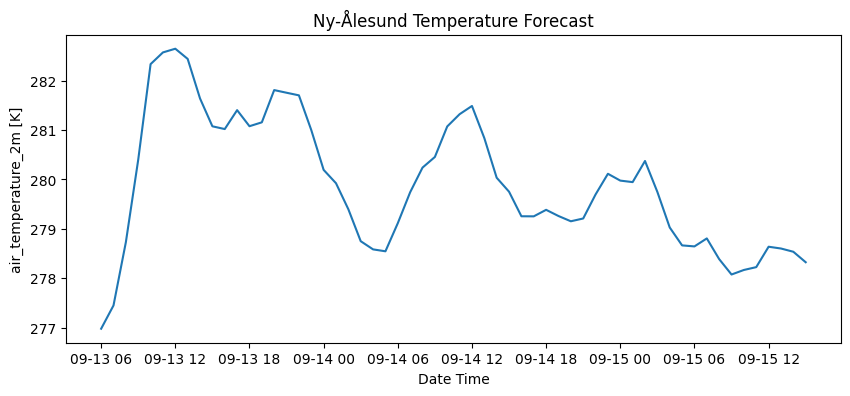

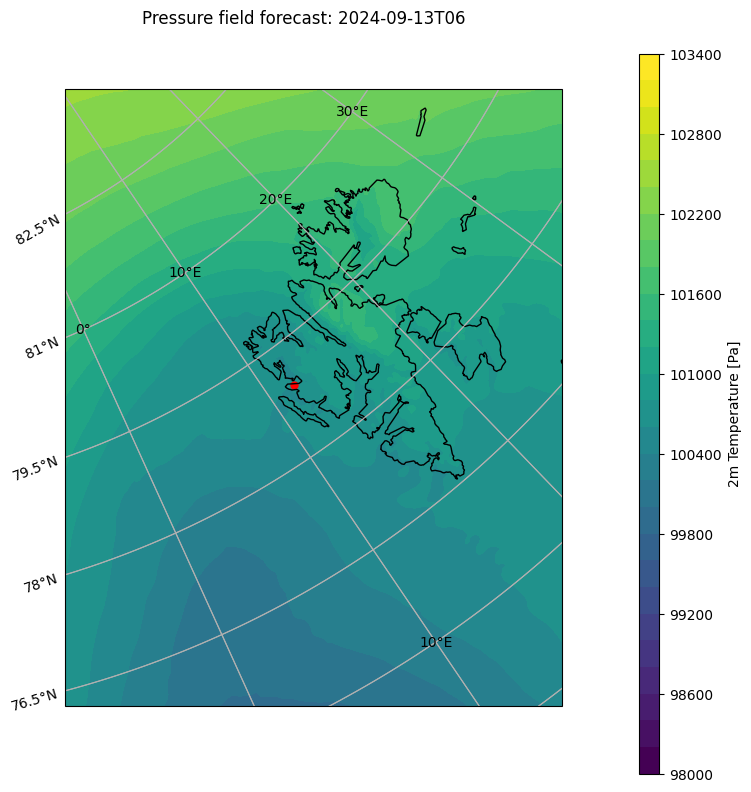

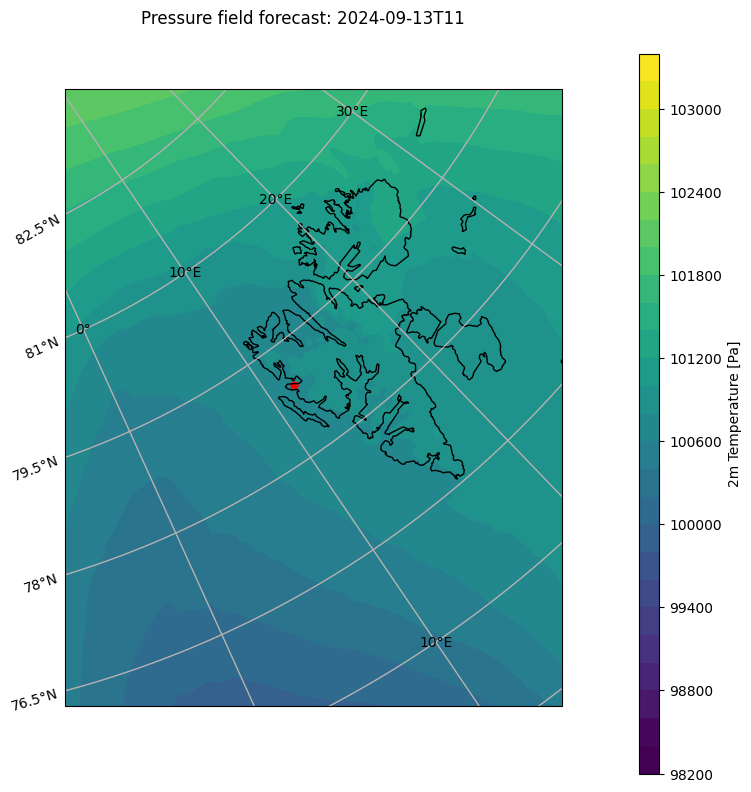

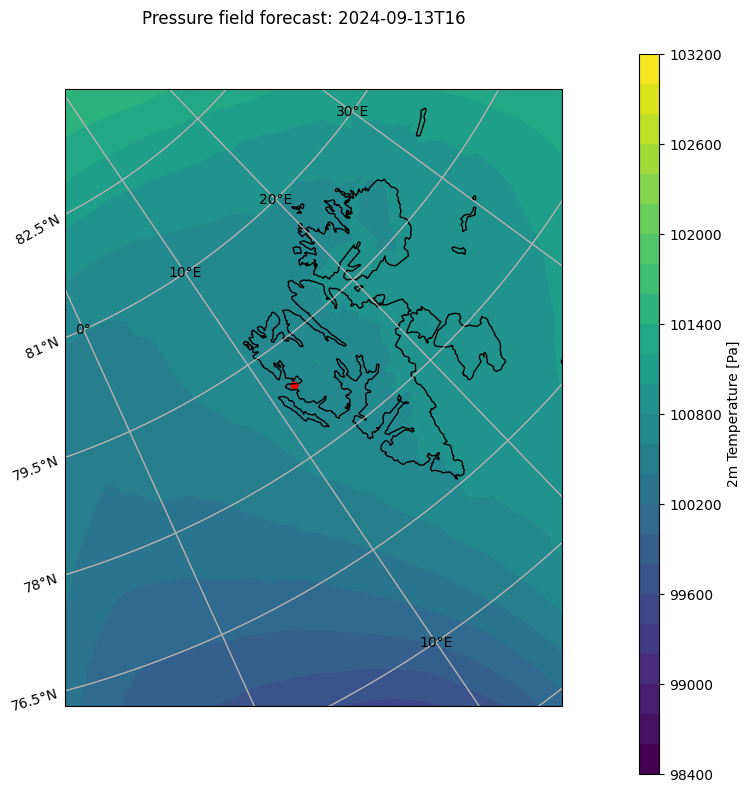

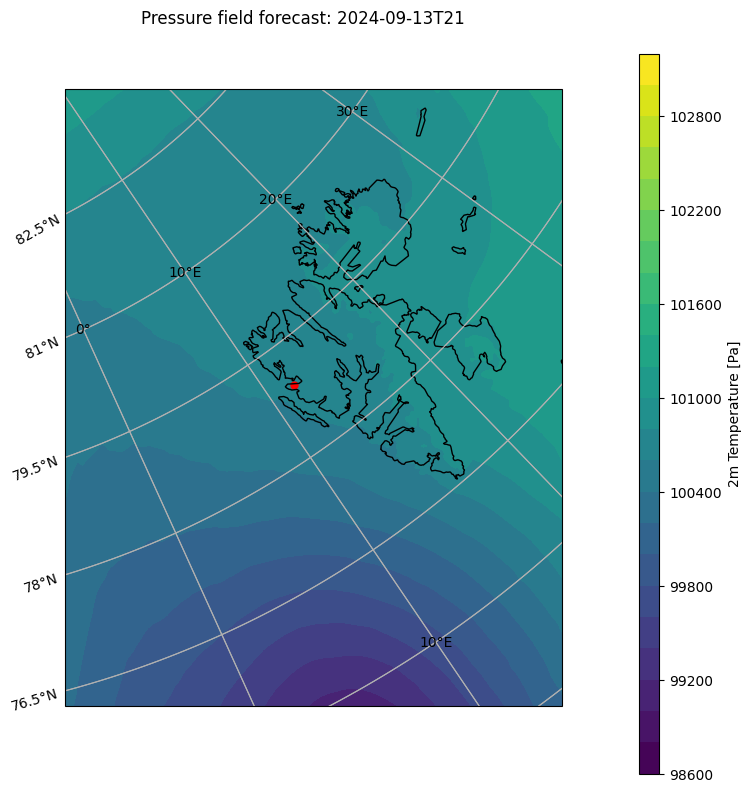

In [398]:
lon = locations['Ny-Alesund']['lon']
lat = locations['Ny-Alesund']['lat']

plot_timeseries(lon = lon , lat = lat , data_var = 'air_temperature_2m', dataset=dataset, title = 'Ny-Ålesund Temperature Forecast')


plot_pressure_map(ensemble_mem=1, timestep=0, lon=lon, lat=lat, dataset=dataset)

plot_pressure_map(ensemble_mem=1, timestep=5, lon=lon, lat=lat, dataset=dataset)

plot_pressure_map(ensemble_mem=1, timestep=10, lon=lon, lat=lat, dataset=dataset)

plot_pressure_map(ensemble_mem=1, timestep=15, lon=lon, lat=lat, dataset=dataset)


Plot the temperature and wind forecast from AROMEArctic as a map for 2020 February 04 14:00 UTC. And a point-forecast initialized on 2020 February 04 00:00 UTC  for Tromsø. The forecast date is related to a polar low which made landfall in 2020 directly at Tromsø. 

In [399]:
url = 'https://thredds.met.no/thredds/dodsC/aromearcticarchive/2020/02/04/arome_arctic_extracted_2_5km_20200204T12Z.nc'
dataset = xr.open_dataset(url, engine='netcdf4')
dataset

<xarray.Dataset> Size: 111GB
Dimensions:                                                             (
                                                                         time: 67,
                                                                         pressure: 13,
                                                                         height_above_msl: 1,
                                                                         height0: 1,
                                                                         height1: 1,
                                                                         ...
                                                                         atmosphere_as_single_layer: 1,
                                                                         grib1_vLevel4: 1,
                                                                         grib1_vLevel7: 1,
                                                                         top_of_atmosphere: 1,
                                                                         x: 739,
                                                                         y: 949)
Coordinates: (12/20)
  * time                                                                (time) datetime64[ns] 536B ...
  * pressure                                                            (pressure) float32 52B ...
  * height_above_msl                                                    (height_above_msl) float32 4B ...
  * height0                                                             (height0) float32 4B ...
  * height1                                                             (height1) float32 4B ...
  * height2                                                             (height2) float32 8B ...
    ...                                                                  ...
  * grib1_vLevel7                                                       (grib1_vLevel7) float32 4B ...
  * top_of_atmosphere                                                   (top_of_atmosphere) int16 2B ...
  * x                                                                   (x) float32 3kB ...
  * y                                                                   (y) float32 4kB ...
    longitude                                                           (y, x) float64 6MB ...
    latitude                                                            (y, x) float64 6MB ...
Data variables: (12/96)
    forecast_reference_time                                             datetime64[ns] 8B ...
    p00                                                                 float64 8B ...
    ap0                                                                 (hybrid0) float64 16B ...
    b0                                                                  (hybrid0) float64 16B ...
    p01                                                                 float64 8B ...
    ap1                                                                 (hybrid1) float64 8B ...
    ...                                                                  ...
    wind_direction                                                      (time, height3, y, x) float32 188MB ...
    wind_speed                                                          (time, height3, y, x) float32 188MB ...
    precipitation_amount_acc                                            (time, height0, y, x) float32 188MB ...
    snowfall_amount_acc                                                 (time, height0, y, x) float32 188MB ...
    wind_speed_of_gust                                                  (time, height3, y, x) float32 188MB ...
    fog_area_fraction                                                   (time, height0, y, x) float32 188MB ...
Attributes: (12/17)
    Conventions:                     CF-1.6
    institution:                     Norwegian Meteorological Institute, MET ...
    creator_url:                     met.no
    summary:                         AROM

In [405]:
u_wind = dataset.data_vars['x_wind_10m']
u_wind

<xarray.DataArray 'x_wind_10m' (time: 67, height3: 1, y: 949, x: 739)> Size: 188MB
[46987837 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 536B 2020-02-04T12:00:00 ... 2020-02-07T...
  * height3    (height3) float32 4B 10.0
  * x          (x) float32 3kB 2.786e+05 2.811e+05 ... 2.121e+06 2.124e+06
  * y          (y) float32 4kB -8.979e+05 -8.954e+05 ... 1.47e+06 1.472e+06
    longitude  (y, x) float64 6MB ...
    latitude   (y, x) float64 6MB ...
Attributes:
    long_name:      Zonal 10 metre wind (U10M)
    standard_name:  x_wind
    units:          m/s
    grid_mapping:   projection_lambert
    _ChunkSizes:    [  1   1 949 739]

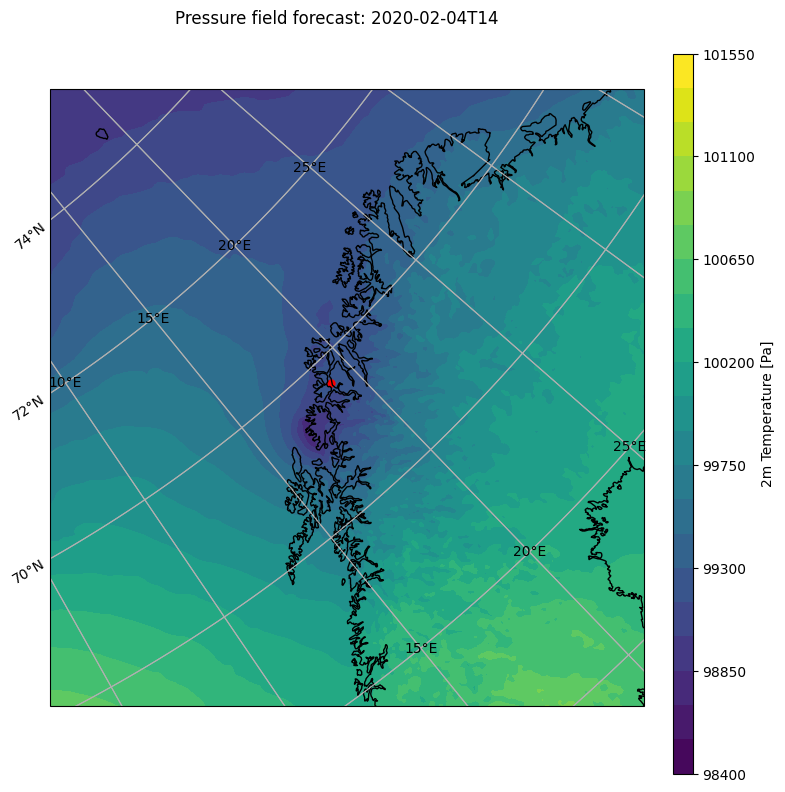

In [404]:
lon = locations['Tromso']['lon']
lat = locations['Tromso']['lat']

# plot_timeseries(lon = lon , lat = lat , data_var = 'air_temperature_2m', dataset=dataset, title = 'Ny-Ålesund Temperature Forecast')

plot_pressure_map(ensemble_mem=1, timestep='2020-02-04T14', lon=lon, lat=lat, dataset=dataset)